# Projet Deep Learning - POS Tagging 

### Import des Librairies 

In [149]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np



from matplotlib import pyplot as plt


import pandas as pd

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Load Data (Corpora)

In [121]:
import nltk
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('brown')
nltk.download('universal_tagset')

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

#Load des corpus + POS tag depuis nltk
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\laams\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\laams\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\laams\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\laams\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [151]:
tagged_sentences[0]


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [120]:
# Informations Generales
total_sentences = len(tagged_sentences)
unique_words = len(set(word for sentence in tagged_sentences for word, _ in sentence))
unique_tags = len(set(tag for sentence in tagged_sentences for _, tag in sentence))
avg_sentence_length = sum(len(sentence) for sentence in tagged_sentences) / total_sentences

# Affichage des informations
print(f"Nombre total de phrases: {total_sentences}")
print(f"Nombre total de mots: {unique_words}")
print(f"Nombre total de tags unique: {unique_tags}")
print(f"Longueur moyennes d'une phrase: {avg_sentence_length:.2f} words per sentence")

Nombre total de phrases: 72202
Nombre total de mots: 67067
Nombre total de tags unique: 12
Longueur moyennes d'une phrase: 21.07 words per sentence


### Visualisation de données 

##### Differents POS Tag present 

In [28]:
# Extract all unique tags
all_tags = set(tag for sentence in tagged_sentences for _, tag in sentence)

# Print the list of unique tags
print("List of unique tags:")
for tag in sorted(all_tags):
    print(tag)


List of unique tags:
.
ADJ
ADP
ADV
CONJ
DET
NOUN
NUM
PRON
PRT
VERB
X


##### Distribution des POS Tag

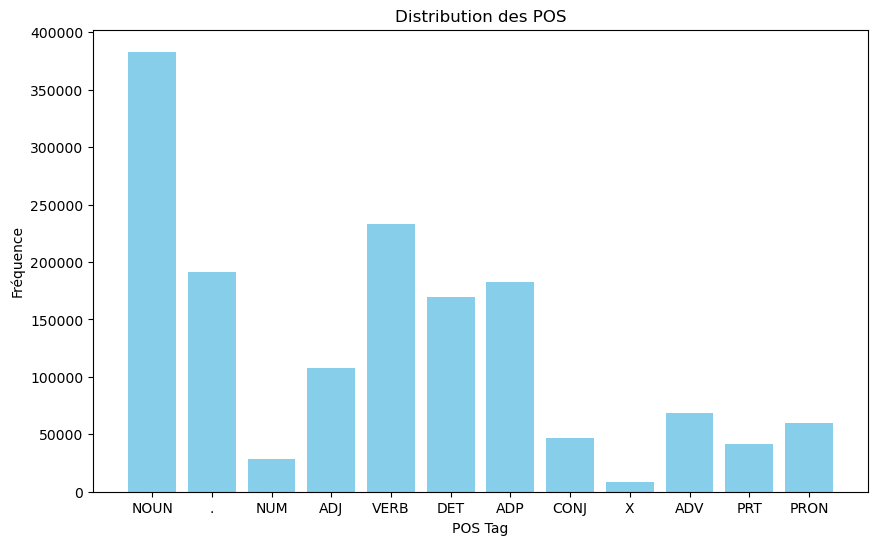

In [157]:
import matplotlib.pyplot as plt
from collections import Counter


# Extraction des parties du discours pour toutes les phrases
all_pos_tags = [tag for sentence in tagged_sentences for _, tag in sentence]

# Compter la fréquence de chaque partie du discours
pos_counts = Counter(all_pos_tags)

# Graphique
plt.figure(figsize=(10, 6))
plt.bar(pos_counts.keys(), pos_counts.values(), color='skyblue')
plt.title('Distribution des POS')
plt.xlabel('POS Tag')
plt.ylabel('Fréquence')
plt.show()


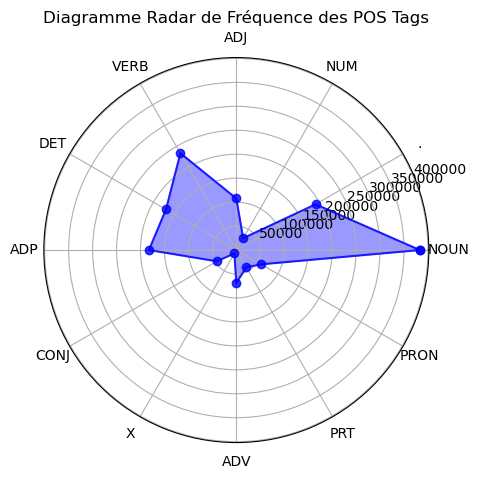

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# Calculer la fréquence des POS tags
pos_freq = Counter(all_pos_tags)

# Créer un diagramme radar
categories = list(pos_freq.keys())
values = list(pos_freq.values())
num_categories = len(categories)

angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

# Plot
plt.figure(figsize=(5, 5))
plt.polar(angles, values, marker='o', linestyle='solid', color='b', alpha=0.8)
plt.fill(angles, values, color='b', alpha=0.4)

plt.title('Diagramme Radar de Fréquence des POS Tags')
plt.xticks(angles[:-1], categories)
plt.show()


##### WordCloud pour chaque POS Tag

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extraction des parties du discours pour toutes les phrases
all_pos_tags = [tag for sentence in tagged_sentences for _, tag in sentence]

# Compter la fréquence de chaque partie du discours
pos_counts = Counter(all_pos_tags)

# Concaténer les mots par partie du discours
pos_text = {pos: ' '.join([word for sentence in tagged_sentences for word, tag in sentence if tag == pos]) for pos in pos_counts.keys()}

# Créer le nuage de mots pour chaque partie du discours
for pos, text in pos_text.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuage de Mots pour la Partie du Discours {pos}')
    plt.axis('off')
    plt.show()


##### Longueur des phrases

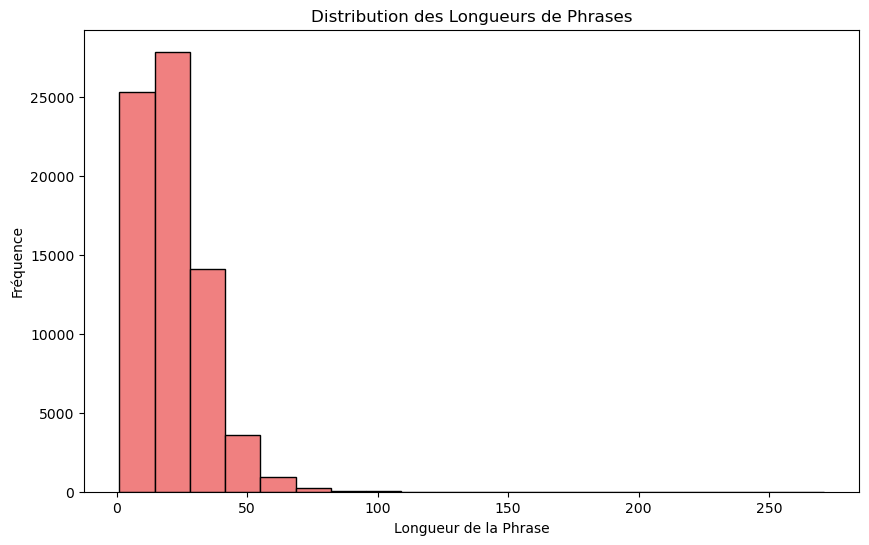

In [131]:
# Calculer la longueur de chaque phrase
sentence_lengths = [len(sentence) for sentence in tagged_sentences]

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution des Longueurs de Phrases')
plt.xlabel('Longueur de la Phrase')
plt.ylabel('Fréquence')
plt.show()

##### Matrice de Transition d'un Tag vers un autre

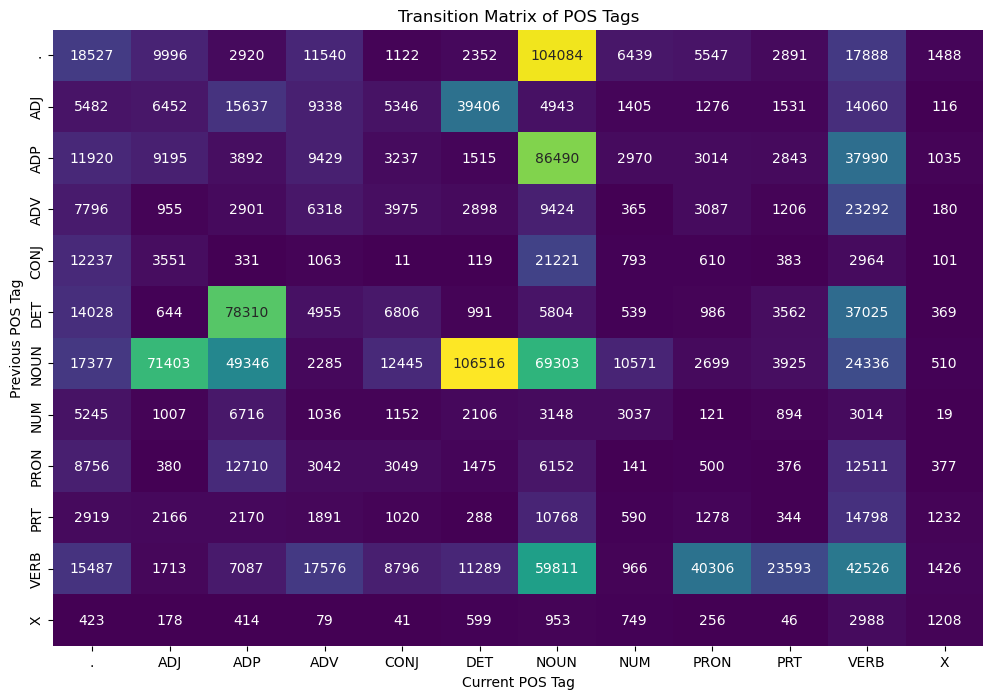

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import ConditionalFreqDist


# Extraction des POS pour toutes les phrases
all_pos_tags = [tag for sentence in (tagged_sentences) for _, tag in sentence]

# ConditionalFreqDist
cfd = ConditionalFreqDist((prev_tag, tag) for sentence in tagged_sentences for (_, prev_tag), (_, tag) in nltk.bigrams(sentence))

# Préparer les données pour le graphique
tags = sorted(set(all_pos_tags))
data = {prev_tag: [cfd[prev_tag][tag] for tag in tags] for prev_tag in tags}
df = pd.DataFrame(data, index=tags)

# Graphique
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt="d", cmap="viridis", cbar=False)
plt.title('Transition Matrix of POS Tags')
plt.xlabel('POS Tag Courant')
plt.ylabel('POS Tag Precedent')
plt.show()


##### Relation Frequentes d'un Echantillon 

In [156]:
import networkx as nx
import random

#Échantillonnage de mots tagué
sampled_tagged_words = random.sample(tagged_words, min(50, len(tagged_words)))

# Graphique
G = nx.Graph()
tag_pairs = zip(sampled_tagged_words[:-1], sampled_tagged_words[1:])
G.add_edges_from(tag_pairs)

# Visualisation du réseaux
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, font_size=8, node_size=20, font_color='red', edge_color='gray', alpha=0.7)
plt.title('POS Bi-grams Network (Echantillon)')
plt.show()


### Division des données en mots (X) et Tag (Y)

In [171]:
# Sequence d'entré
X = [] 
# Sequence de sortie
Y = [] 

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contient le mot
        Y_sentence.append(entity[1])  # entity[1] contient le tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [172]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [173]:
print("Nombre total de phrases: {}".format(len(X)))
print("Taille du Vocabulaire: {}".format(num_words))
print("Nombre totale de Tag: {}".format(num_tags))

Nombre total de phrases: 72202
Taille du Vocabulaire: 59448
Nombre totale de Tag: 12


In [177]:
import random

# Générer un index aléatoire
random_index = random.randint(0, len(X) - 1)

# Afficher l'exemple X et Y correspondant à l'index aléatoire
print('Exemple X :', X[random_index])
print('Exemple Y :', Y[random_index])


Exemple X : ['Transamerica', 'Corp.', ',', 'San', 'Francisco', ',', 'said', '0', 'third-quarter', 'profit', 'was', 'essentially', 'flat', 'despite', 'a', 'large', 'one-time', 'gain', 'a', 'year', 'earlier', '.']
Exemple Y : ['NOUN', 'NOUN', '.', 'NOUN', 'NOUN', '.', 'VERB', 'X', 'NOUN', 'NOUN', 'VERB', 'ADV', 'ADJ', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'DET', 'NOUN', 'ADJ', '.']


In [184]:
# On a un problème Many to Many
# Il faut s'assurer que la taille de l'input = taille de l'output

# Générer un index aléatoire
random_index = random.randint(0, len(X) - 1)

print("Taille input : {}".format(len(X[random_index])))
print("Taille output : {}".format(len(Y[random_index])))

Taille input : 42
Taille output : 42


##### Creation du Tokenizer pour les mots 

In [185]:
word_tokenizer = Tokenizer()                      # Instance tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # utiliser le tokenizer sur les données

##### Creation du Tokenizer pour les Tags

In [60]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [188]:
index_random = random.randint(0, len(X) - 1)


print("** Donnée Raw **", "\n", "-"*100, "\n")
print('X: ', X[index_random], '\n')
print('Y: ', Y[index_random], '\n')
print()
print("** Donnée Encodé **", "\n", "-"*100, "\n")
print('X: ', X_encoded[index_random], '\n')
print('Y: ', Y_encoded[index_random], '\n')

** Donnée Raw ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['But', 'with', 'the', 'renewal', 'of', 'interference', 'in', '1954', '(', 'as', 'with', 'its', 'beginning', 'in', '1835', ')', ',', 'the', 'improvement', 'was', 'impaired', '.'] 

Y:  ['CONJ', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NUM', '.', 'ADP', 'ADP', 'DET', 'NOUN', 'ADP', 'NUM', '.', '.', 'DET', 'NOUN', 'VERB', 'VERB', '.'] 


** Donnée Encodé ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [30, 18, 1, 8473, 4, 3053, 8, 3178, 66, 17, 18, 50, 722, 8, 22285, 65, 2, 1, 2163, 13, 10332, 3] 

Y:  [9, 4, 5, 1, 4, 1, 4, 11, 3, 4, 4, 5, 1, 4, 11, 3, 3, 5, 1, 2, 2, 3] 



In [189]:
# Verification de la longueur des mot encodé = tag encodé

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} phrases ont des tailles differentes.".format(sum(different_length)))

0 phrases ont des tailles differentes.


In [190]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Phrase la plus longue: {}".format(max(lengths)))

Phrase la plus longue: 271


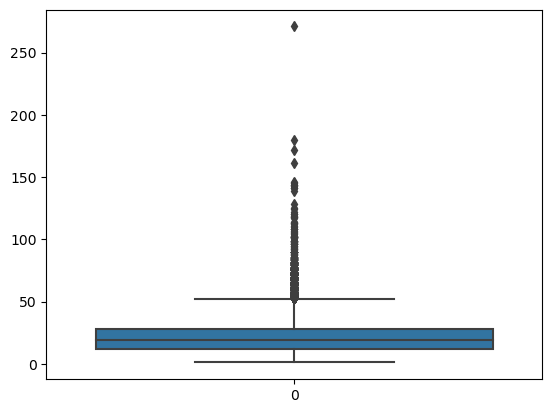

In [191]:
sns.boxplot(lengths)
plt.show()

##### Padding et Choix du hyperparametre (MAX_SEQ_LENGTH)

In [192]:
MAX_SEQ_LENGTH = 100
  
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [194]:
# Affichage de la premiere sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


In [195]:
X, Y = X_padded, Y_padded

In [69]:
path = 'GoogleNews-vectors-negative300.bin'


# load word2vec pour le word embeddings
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [196]:
# Efficacité word2vec 
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929388165473938),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.4422132968902588),
 ('Jackson', 0.4402504861354828),
 ('NECN_Alison', 0.4331282675266266),
 ('Whitfield', 0.42834722995758057),
 ('Ida_Vandross', 0.4208453297615051),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [198]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # Les mots dans word2vec ont 300 dimensions
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# Matrice d'Embedding
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# Dictionnaire qui mappe les mots a leur index
word2id = word_tokenizer.word_index

# Remplissage de la matrice d'Embedding
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [200]:
print("Embedding matrice shape: {}".format(embedding_weights.shape))

Embedding matrice shape: (59449, 300)


##### one-hot encoding pour l'output (Y)

In [202]:
Y = to_categorical(Y)

In [203]:
# Shaoe de Y
print(Y.shape)

(72202, 100, 13)


##### Split data en training, validation et testing sets

In [204]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [205]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [206]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape des sequences d\'entrées: {}'.format(X_train.shape))
print('Shape des sequences de sortie: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape des sequences d\'entrées: {}'.format(X_validation.shape))
print('Shape des sequences de sortie: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape des sequences d\'entrées: {}'.format(X_test.shape))
print('Shape des sequences de sortie: {}'.format(Y_test.shape))

TRAINING DATA
Shape des sequences d'entrées: (52165, 100)
Shape des sequences de sortie: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape des sequences d'entrées: (9206, 100)
Shape des sequences de sortie: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape des sequences d'entrées: (10831, 100)
Shape des sequences de sortie: (10831, 100, 13)


# Vanilla RNN

In [78]:
# Nombre total de tags
NUM_CLASSES = Y.shape[2]

In [208]:
rnn_model = Sequential()

# Embedding Layer
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # Nombre de mots unique
                        output_dim    =  EMBEDDING_SIZE,          # Taille de vecteur dans lequel les mots sont represente
                        input_length  =  MAX_SEQ_LENGTH,          # taille de sequence d'entree
                        trainable     =  False                    # Ne pas mettre a jour les embeddings
))

# RNN layer
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  
))


rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [209]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [210]:
rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_6 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 24205 (94.55 KB)
Non-trainable params: 17834700 (68.03 MB)
_________________________________________________________________


In [211]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 18s 39ms/step - loss: 0.5084 - acc: 0.8509 - val_loss: 0.3567 - val_acc: 0.8943
Epoch 2/10
408/408 [==============================] - 16s 38ms/step - loss: 0.2938 - acc: 0.9109 - val_loss: 0.2466 - val_acc: 0.9249
Epoch 3/10
408/408 [==============================] - 17s 43ms/step - loss: 0.2235 - acc: 0.9305 - val_loss: 0.2018 - val_acc: 0.9360
Epoch 4/10
408/408 [==============================] - 13s 32ms/step - loss: 0.1901 - acc: 0.9393 - val_loss: 0.1762 - val_acc: 0.9435
Epoch 5/10
408/408 [==============================] - 13s 32ms/step - loss: 0.1692 - acc: 0.9459 - val_loss: 0.1599 - val_acc: 0.9488
Epoch 6/10
408/408 [==============================] - 15s 36ms/step - loss: 0.1555 - acc: 0.9501 - val_loss: 0.1490 - val_acc: 0.9518
Epoch 7/10
408/408 [==============================] - 15s 36ms/step - loss: 0.1459 - acc: 0.9526 - val_loss: 0.1407 - val_acc: 0.9540
Epoch 8/10
408/408 [==============================] - 21s 52ms

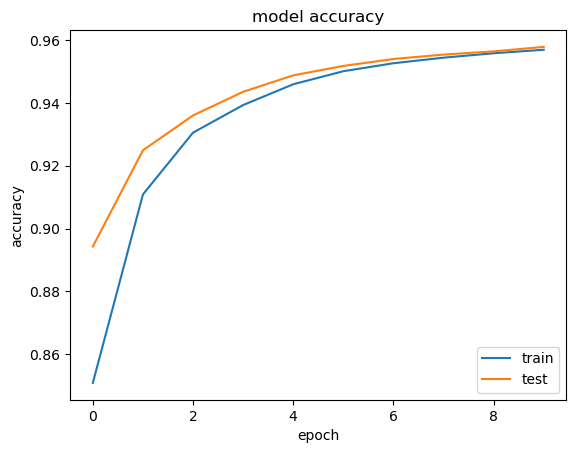

In [212]:
# Visualisation de training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

##### pre-trained embedding weights

In [213]:

rnn_model = Sequential()


rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  MAX_SEQ_LENGTH,          
                        weights       = [embedding_weights],      # matrice de word embedding
                        trainable     =  True                     
))

rnn_model.add(SimpleRNN(64, 
              return_sequences=True  
))

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [214]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [215]:
rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_7 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 17858905 (68.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [216]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
408/408 [==============================] - 97s 234ms/step - loss: 0.1750 - acc: 0.9643 - val_loss: 0.0344 - val_acc: 0.9891
Epoch 2/5
408/408 [==============================] - 109s 267ms/step - loss: 0.0264 - acc: 0.9911 - val_loss: 0.0270 - val_acc: 0.9906
Epoch 3/5
408/408 [==============================] - 101s 248ms/step - loss: 0.0197 - acc: 0.9930 - val_loss: 0.0254 - val_acc: 0.9909
Epoch 4/5
408/408 [==============================] - 82s 200ms/step - loss: 0.0169 - acc: 0.9939 - val_loss: 0.0250 - val_acc: 0.9911
Epoch 5/5
408/408 [==============================] - 109s 267ms/step - loss: 0.0149 - acc: 0.9946 - val_loss: 0.0250 - val_acc: 0.9912


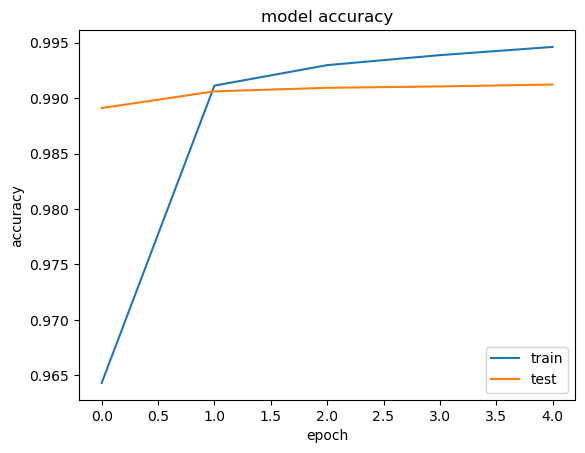

In [217]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [218]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         
                         output_dim    = EMBEDDING_SIZE,          
                         input_length  = MAX_SEQ_LENGTH,          
                         weights       = [embedding_weights],     
                         trainable     = True                     
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [219]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [220]:
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           93440     
                                                                 
 time_distributed_8 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17928985 (68.39 MB)
Trainable params: 17928985 (68.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [103]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
408/408 [==============================] - 104s 255ms/step - loss: 0.2124 - acc: 0.9416 - val_loss: 0.0445 - val_acc: 0.9876
Epoch 2/5
408/408 [==============================] - 132s 324ms/step - loss: 0.0327 - acc: 0.9898 - val_loss: 0.0296 - val_acc: 0.9899
Epoch 3/5
408/408 [==============================] - 141s 345ms/step - loss: 0.0232 - acc: 0.9918 - val_loss: 0.0262 - val_acc: 0.9906
Epoch 4/5
408/408 [==============================] - 123s 302ms/step - loss: 0.0197 - acc: 0.9928 - val_loss: 0.0248 - val_acc: 0.9910
Epoch 5/5
408/408 [==============================] - 132s 324ms/step - loss: 0.0176 - acc: 0.9935 - val_loss: 0.0243 - val_acc: 0.9912


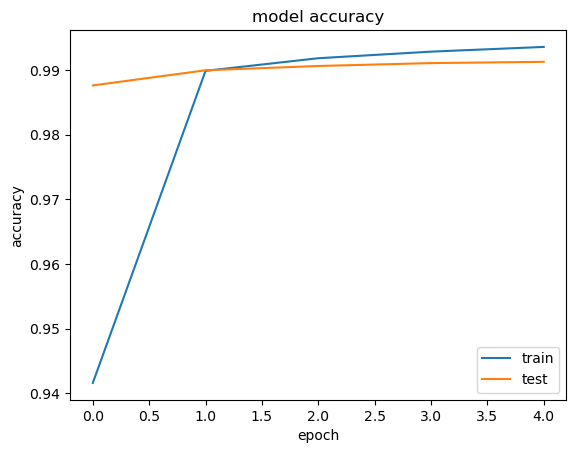

In [104]:
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [221]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [222]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [223]:
# check summary of model
gru_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 gru_1 (GRU)                 (None, 100, 64)           70272     
                                                                 
 time_distributed_9 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17905817 (68.31 MB)
Trainable params: 17905817 (68.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [109]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
408/408 [==============================] - 140s 344ms/step - loss: 0.1260 - acc: 0.9671 - val_loss: 0.0338 - val_acc: 0.9887
Epoch 2/5
408/408 [==============================] - 127s 311ms/step - loss: 0.0265 - acc: 0.9907 - val_loss: 0.0265 - val_acc: 0.9904
Epoch 3/5
408/408 [==============================] - 124s 303ms/step - loss: 0.0204 - acc: 0.9925 - val_loss: 0.0246 - val_acc: 0.9910
Epoch 4/5
408/408 [==============================] - 118s 290ms/step - loss: 0.0178 - acc: 0.9933 - val_loss: 0.0239 - val_acc: 0.9912
Epoch 5/5
408/408 [==============================] - 108s 265ms/step - loss: 0.0161 - acc: 0.9939 - val_loss: 0.0237 - val_acc: 0.9914


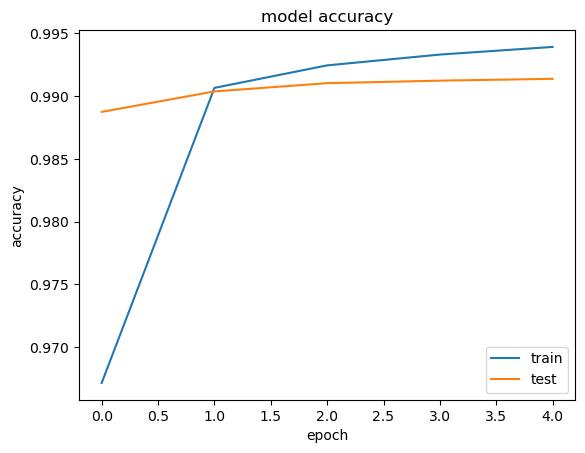

In [110]:
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [224]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [225]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [226]:
# check summary of model
bidirect_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 300)          17834700  
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 128)          186880    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeD  (None, 100, 13)           1677      
 istributed)                                                     
                                                                 
Total params: 18023257 (68.75 MB)
Trainable params: 18023257 (68.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [114]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
408/408 [==============================] - 135s 322ms/step - loss: 0.2346 - acc: 0.9451 - val_loss: 0.0317 - val_acc: 0.9902
Epoch 2/5
408/408 [==============================] - 131s 321ms/step - loss: 0.0234 - acc: 0.9924 - val_loss: 0.0219 - val_acc: 0.9926
Epoch 3/5
408/408 [==============================] - 138s 339ms/step - loss: 0.0160 - acc: 0.9946 - val_loss: 0.0194 - val_acc: 0.9934
Epoch 4/5
408/408 [==============================] - 165s 404ms/step - loss: 0.0127 - acc: 0.9957 - val_loss: 0.0183 - val_acc: 0.9938
Epoch 5/5
408/408 [==============================] - 160s 393ms/step - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0179 - val_acc: 0.9940


In [115]:
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [227]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 3s 9ms/step - loss: 0.0249 - acc: 0.9912
Loss: 0.02494375966489315,
Accuracy: 0.9911762475967407


In [228]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 6s 15ms/step - loss: 2.5635 - acc: 0.8154
Loss: 2.5635299682617188,
Accuracy: 0.8153910040855408


In [229]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 8s 20ms/step - loss: 2.5661 - acc: 0.8056
Loss: 2.566093921661377,
Accuracy: 0.8055553436279297


In [230]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 9s 23ms/step - loss: 2.5671 - acc: 0.0575
Loss: 2.5670969486236572,
Accuracy: 0.057509925216436386


In [277]:
import numpy as np

def predict_pos_tags(sentence, word_tokenizer, model, tag_tokenizer, max_seq_length=100):    
    # Encoder les tokens avec le tokenizer
    encoded_tokens = word_tokenizer.texts_to_sequences([sentence])
    
    # Remplir les séquences avec des zéros ou tronquer si nécessaire
    padded_tokens = pad_sequences(encoded_tokens, maxlen=max_seq_length, padding="pre", truncating="post")
    
    # Utiliser le modèle pour prédire les POS tags
    predictions = model.predict(padded_tokens)
    
    pred_indices = np.argmax(predictions, axis=-1)
    # Arrondir les résultats et ignorer les zéros (padding)
    rounded_predictions = np.round(pred_indices)

    non_zero_list = [x for x in rounded_predictions[0] if x != 0]

    pred_tags = []
    pred_tags_sentence = []

    for pred_index in non_zero_list:
            # Décoder les tags depuis le format one-hot encoding
            decoded_tag = tag_tokenizer.index_word[pred_index]

            pred_tags_sentence.append(decoded_tag)
    pred_tags.append(pred_tags_sentence)
    return pred_tags

# Utilisation de la fonction pour prédire les POS tags d'une phrase
input_sentence = "The team is winning the game right now"
predicted_tags = predict_pos_tags(input_sentence, word_tokenizer, rnn_model, tag_tokenizer)
print('Resultat premier modèle: {}\n'.format(predicted_tags))
predicted_tags2 = predict_pos_tags(input_sentence, word_tokenizer, lstm_model, tag_tokenizer)
print('Resultat deucième modèle: {}\n'.format(predicted_tags2))



1/1 [==============================] - 0s 41ms/step
Resultat premier modèle: [['det', 'noun', 'verb', 'verb', 'det', 'noun', 'noun', 'adv']]

1/1 [==============================] - 0s 43ms/step
Resultat deucième modèle: [['pron', 'adv', 'adv', 'num', 'pron', 'num', 'adv', 'adv']]

